In [1]:
import pystan
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

years = list(range(2010, 2020))

from random import seed, gauss
from collections import defaultdict

seed(1234)

intercept_mu, intercept_sigma, slope_mu, slope_sigma, error_mu, error_sigma = 20, 5, 5, 2, 0.1, 5

simulated_data = defaultdict(list)

for i, state in enumerate(states, 1):
    intercept = gauss(intercept_mu, intercept_sigma)
    slope = gauss(slope_mu, slope_sigma)
    for j, year in enumerate(years, 1):
        error = gauss(error_mu, error_sigma)
        simulated_data["state"].append(state)
        simulated_data["year"].append(year)
        simulated_data["intercept"].append(intercept)
        simulated_data["slope"].append(slope)
        simulated_data["error"].append(error)
        simulated_data['state_numeric'].append(i)
        simulated_data['year_numeric'].append(j)
        simulated_data["rainfall"].append(intercept + (slope * j) + error)


import pandas as pd

simulated_data_df = pd.DataFrame(simulated_data)


In [3]:
simulated_data_df.head(20)

,state,year,intercept,slope,error,state_numeric,year_numeric,rainfall
0,AL,2010,25.271098,4.548885,11.085203,1,1,40.905186
1,AL,2011,25.271098,4.548885,0.617459,1,2,34.986328
2,AL,2012,25.271098,4.548885,6.230988,1,3,45.148742
3,AL,2013,25.271098,4.548885,-2.360063,1,4,41.106577
4,AL,2014,25.271098,4.548885,-0.890575,1,5,47.124951
5,AL,2015,25.271098,4.548885,-1.744542,1,6,50.819869
6,AL,2016,25.271098,4.548885,0.479972,1,7,57.593268
7,AL,2017,25.271098,4.548885,-3.556230,1,8,58.105952
8,AL,2018,25.271098,4.548885,8.752349,1,9,74.963417
9,AL,2019,25.271098,4.548885,1.796433,1,10,72.556386


In [4]:
rainfall_stan_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int county[N];
}
parameters {
  real intercept_mu;
  real<lower=0> intercept_sigma;
  real slope_mu;
  real<lower=0> slope_sigma;
  real<lower=0> error_sigma;
  vector[J] intercept;
  vector[J] slope; 

}

transformed parameters {

  vector[N] predicted_rainfall;

  for (i in 1:N)
    predicted_rainfall[i] <- intercept[county[i]] + x[i] * slope[county[i]];
}


model {
  intercept_mu ~ normal(0, 100);
  slope_mu ~ normal(0, 100);

  intercept ~ normal(intercept_mu, intercept_sigma);
  slope ~ normal(slope_mu, slope_sigma);
  y ~ normal(intercept[county] + slope[county].*x, error_sigma);
}
"""

rainfall_stan_compile = pystan.StanModel(model_code=rainfall_stan_model)

rainfall_stan_input_data = dict(
    N=len(simulated_data_df),
    J=len(states),
    county=simulated_data_df.state_numeric.values,
    x=simulated_data_df.year_numeric.values,
    y=simulated_data_df.rainfall.values,
)


rainfall_stan_fit = rainfall_stan_compile.sampling(
    data=rainfall_stan_input_data, iter=1000, chains=4
)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_02f298ae594eff2bbf673e069312d324 NOW.


In [5]:
import pandas as pd
from collections import defaultdict

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

rainfall_stan_fit_df = rainfall_stan_fit.to_dataframe()
estimated_intercept = rainfall_stan_fit_df.iloc[:, range(8, 8 + 51)].mean().to_list()
estimated_slope = rainfall_stan_fit_df.iloc[:, range(59, 59 + 51)].mean().to_list()

all_estimates = defaultdict(list)

all_estimates_zip = zip(states, estimated_intercept, estimated_slope)
all_estimates_df = pd.DataFrame(
    all_estimates_zip, columns=["states", "estimated_interecept", "estimated_slope"]
)

all_estimates_df.head(10)

,states,estimated_interecept,estimated_slope
0,AL,26.714319,4.556785
1,AK,18.970932,6.815828
2,AZ,15.224190,4.944609
3,AR,23.462142,6.306657
4,CA,19.941042,1.087507
5,CO,24.152504,5.284376
6,CT,21.658969,2.994738
7,DC,19.463848,6.948277
8,DE,18.917018,5.662122
9,FL,23.061378,5.793869


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B659151250>,
      dtype=object)

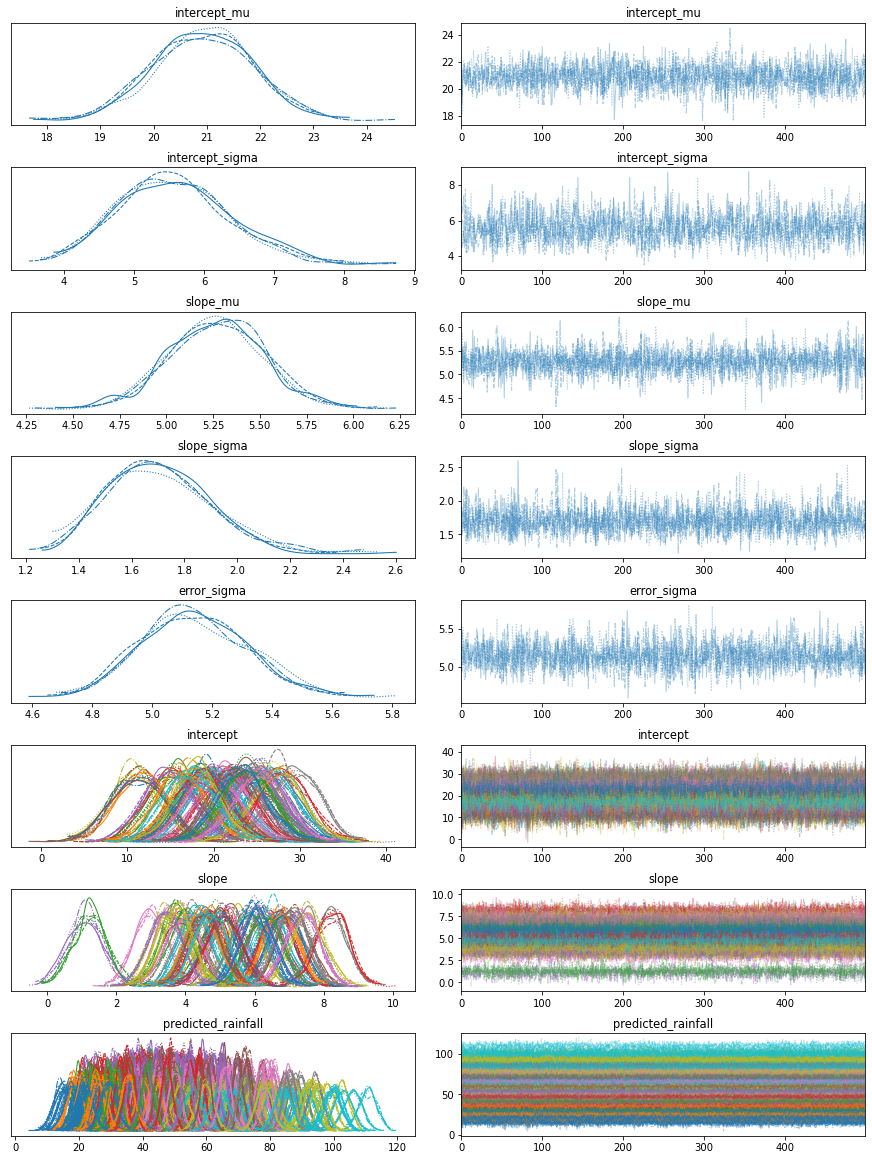

In [6]:
az.plot_trace(rainfall_stan_fit)

In [7]:
print(rainfall_stan_fit)

Inference for Stan model: anon_model_02f298ae594eff2bbf673e069312d324.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept_mu             20.93    0.02   0.92  19.15  20.31  20.95  21.55  22.72   2614    1.0
intercept_sigma           5.58    0.02    0.8   4.15   5.01   5.54   6.08   7.27   1591    1.0
slope_mu                  5.27  4.6e-3   0.26   4.76    5.1   5.27   5.44   5.78   3046    1.0
slope_sigma                1.7  3.5e-3    0.2   1.37   1.57   1.69   1.83   2.13   3069    1.0
error_sigma               5.14  3.3e-3   0.18   4.82   5.02   5.13   5.26   5.51   2976    1.0
intercept[1]             26.71    0.04   2.93  21.01   24.7  26.75   28.7   32.5   4309    1.0
intercept[2]             18.97    0.04   2.91  13.37  17.02  18.94  20.91  24.89   5107    1.0
intercept[3]             15.22    0.04   2.89   9.62 